주제: 의료 인프라 분포에 기반한 의료 취약지 탐색 및 고령인구 의료접근성 향상을 위한 시각화 자료 구축
1. API 불러오기
2. 병원데이터 전처리
3. 약국데이터 전처리
4. 인구데이터 전처리
5. Feature engineering
6. 모델링
7. 시각화

의료기관 크기도 확인할 것

In [1]:
import numpy as np
import pandas as pd
import re
import json
import requests
import time
import xml.etree.ElementTree as ET
import folium
import os
import zipfile
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import Point
import geopandas as gpd
import folium
import glob
import branca.colormap as cm
import random
from folium.features import GeoJsonTooltip, GeoJsonPopup
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.cluster import KMeans

In [2]:
from matplotlib import font_manager, rc
# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # 또는 원하는 폰트 경로
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 마이너스 기호가 깨지지 않도록 설정
plt.rcParams['axes.unicode_minus'] = False

## 1. API 불러오기_1번만 작동

In [2]:
# 국립중앙의료원_전국 병·의원 찾기 서비스 인증키 불러오기
url_H = 'http://apis.data.go.kr/B552657/HsptlAsembySearchService/getHsptlMdcncFullDown'
api_H = 'SOecclsdpfuvGmi+5d/vkz3M5XiRZEpLLLAm6oeRb4lI6TJSEsmP4nOvH6DfEznSzCw8o3+Ktedgq18jQIGUmg=='

# 국립중앙의료원_전국 약국 정보 조회 서비스 인증키 불러오기
url_M = "http://apis.data.go.kr/B552657/ErmctInsttInfoInqireService/getParmacyFullDown"
api_M = 'SOecclsdpfuvGmi+5d/vkz3M5XiRZEpLLLAm6oeRb4lI6TJSEsmP4nOvH6DfEznSzCw8o3+Ktedgq18jQIGUmg=='

In [3]:
# API에서 totalCount를 자동으로 가져와 전체 데이터를 수집
def fetch_all_data(api_url, api_key, num_of_rows=100, delay=0.05):  # 50ms 대기

    # totalCount 가져오기
    params = {
        'ServiceKey': api_key,
        'pageNo': '1',
        'numOfRows': '1'  # 한 개만 요청하여 totalCount 확인
    }
    response = requests.get(api_url, params=params)
    
    if response.status_code == 200:
        root = ET.fromstring(response.content)
        total_count_elem = root.find(".//totalCount")
        total_count = int(total_count_elem.text) if total_count_elem is not None else 0
    else:
        print(f"totalCount 가져오기 실패: 상태 코드 {response.status_code}")
        return []
    
    all_responses = []
    total_pages = (total_count // num_of_rows) + (1 if total_count % num_of_rows else 0)

    for page in range(1, total_pages + 1):
        params = {
            'ServiceKey': api_key,
            'pageNo': str(page),
            'numOfRows': str(num_of_rows)
        }
        response = requests.get(api_url, params=params)

        if response.status_code == 200:
            all_responses.append(response.content)
        else:
            print(f"페이지 {page} 요청 실패: 상태 코드 {response.status_code}")

        time.sleep(delay)  # 50ms 대기 (30TPS 제한 맞추기)

    return all_responses

# fetch_all_data()로 가져온 XML 데이터를 DataFrame으로 변환
def convert_xml_to_dataframe(xml_data_list):
    
    parsed_data = []

    for xml_data in xml_data_list:
        root = ET.fromstring(xml_data)

        for item in root.findall(".//item"):
            data = {child.tag: child.text for child in item}
            parsed_data.append(data)

    return pd.DataFrame(parsed_data) if parsed_data else None

In [4]:
# fetach_all_data() 적용
response_H = fetch_all_data(url_H, api_H)
response_M = fetch_all_data(url_M, api_M)

# convert_xml_to_dataframe() 적용
df_H = convert_xml_to_dataframe(response_H)
df_M = convert_xml_to_dataframe(response_M)

# 엑셀 파일로 추출
df_H.to_excel("C:/Users/lglg/OneDrive/캡스톤/병원 풀데이터.xlsx", index=False)
df_M.to_excel("C:/Users/lglg/OneDrive/캡스톤/약국 풀데이터.xlsx", index=False)

## 2. 병원 데이터 전처리

In [3]:
# 병원 풀데이터 불러오기
hos = pd.read_excel("C:/Users/lglg/OneDrive/캡스톤/병원 풀데이터.xlsx")
#hos = pd.read_excel("C:/Users/Admin/OneDrive/캡스톤/병원 풀데이터.xlsx")

# 데이터프레임 형태로 변경
hos_df = pd.DataFrame(hos)
print(hos_df.shape)

(77707, 34)


In [4]:
# 병원 풀데이터에서 필요 없는 변수제거
drop_cols = ['dutyEmcls', 'dutyEmclsName', 'dutyEryn', 'dutyInf', 'dutyMapimg',
             'dutyName', 'dutyTel1', 'dutyTime1c', 'dutyTime1s', 'dutyTime2c',
             'dutyTime2s', 'dutyTime3c', 'dutyTime3s', 'dutyTime4c', 'dutyTime4s',
             'dutyTime5c', 'dutyTime5s', 'hpid', 'postCdn1', 'postCdn2',
             'rnum', 'dutyTime6c', 'dutyTime6s', 'dutyTime7c', 'dutyTime7s',
             'dutyTime8c', 'dutyTime8s', 'dutyEtc', 'dutyTel3']

# 필요한 컬럼만 추려서 삭제
drop_cols_exist = [col for col in drop_cols if col in hos_df.columns]
hos_df = hos_df.drop(columns=drop_cols_exist)

# 각 변수 결측값 개수 확인
print(hos_df.isnull().sum())

dutyAddr      0
dutyDiv       0
dutyDivNam    0
wgs84Lat      0
wgs84Lon      0
dtype: int64


In [5]:
# 'dutyAddr' 열의 이름을 'Jibun'으로 변경
hos_df.rename(columns={'dutyAddr': 'Jibun'}, inplace=True)

### 시도 매핑

In [6]:
# hos_df 복사
hos_df_sido = hos_df.copy()

# 시도 매핑 딕셔너리
sido_mapping = {
    '서울': '서울특별시', '부산': '부산광역시', '대구': '대구광역시',
    '인천': '인천광역시', '광주': '광주광역시', '대전': '대전광역시',
    '울산': '울산광역시', '세종': '세종특별자치시', '경기': '경기도',
    '강원': '강원특별자치도', '충북': '충청북도', '충남': '충청남도',
    '전북': '전북특별자치도', '전남': '전라남도', '경북': '경상북도',
    '경남': '경상남도', '제주': '제주특별자치도', '전라북도': '전북특별자치도'
}

# 시도 추출 사용자 정의 함수 생성
def extract_sido(addr):
    if pd.isnull(addr):
        return None

    # 전체 시도명(풀네임)을 먼저 확인
    for full_sido in sido_mapping.values():
        if addr.startswith(full_sido):
            return full_sido

    # 시도 약어 매핑
    for short, full in sido_mapping.items():
        if addr.startswith(short):
            return full

    return None  # 매칭되지 않는 경우

# 위치 정의 함수 생성
def move_column_after(df, target_col, after_col):

    cols = df.columns.tolist()

    if target_col not in cols or after_col not in cols:
        raise ValueError(f"'{target_col}' 또는 '{after_col}' 컬럼이 존재하지 않습니다.")

    cols.remove(target_col)
    idx = cols.index(after_col)
    cols.insert(idx + 1, target_col)
    return df[cols]

# 'Jibun'에서 'Sido' 추출
hos_df_sido['Sido'] = hos_df_sido['Jibun'].apply(extract_sido)

# 'Sido'를 'Jibun' 다음으로 이동
hos_df_sido = move_column_after(hos_df_sido, 'Sido', 'Jibun')

# 각 변수 결측값 개수 확인
print(hos_df_sido.isnull().sum())

Jibun         0
Sido          0
dutyDiv       0
dutyDivNam    0
wgs84Lat      0
wgs84Lon      0
dtype: int64


In [7]:
sido_list = hos_df_sido['Sido'].dropna().unique().tolist()
print(sorted(sido_list))

['강원특별자치도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시', '서울특별시', '세종특별자치시', '울산광역시', '인천광역시', '전라남도', '전북특별자치도', '제주특별자치도', '충청남도', '충청북도']


### 시군구 매핑

In [8]:
# 전국 법정동 파일 불러오기
all_df = pd.read_csv("C:/Users/lglg/OneDrive/캡스톤/국토교통부_전국 법정동_20250415.csv",encoding='utf-8')
sigungu_list = all_df['시군구명'].dropna().unique().tolist()

# 시군구 추출 함수 정의
def extract_sigungu(addr, sigungu_list):
    if pd.isnull(addr):
        return None
    words = re.findall(r'\w+', addr)  # 단어 단위 추출
    for word in words:
        word = re.sub(r'[^\w가-힣]', '', word)  # 특수문자 제거
        if word in sigungu_list:
            return word
    return None

# hos_df_sido 복사
hos_df_sigungu = hos_df_sido.copy()

# 데이터프레임에서 'Jibun' 열을 기준으로 시군구 추출
hos_df_sigungu['Sigungu'] = hos_df_sigungu['Jibun'].apply(lambda x: extract_sigungu(x, sigungu_list))

# 'Sigungu'를 'Sido' 다음으로 이동
hos_df_sigungu = move_column_after(hos_df_sigungu, 'Sigungu', 'Sido')

# 'Sigungu'가 결측이고 'Sido'가 '세종특별자치시'인 행만 선택하여 보완
mask = (hos_df_sigungu['Sigungu'].isnull()) & (hos_df_sigungu['Sido'] == '세종특별자치시')
hos_df_sigungu.loc[mask, 'Sigungu'] = '세종시'

# 결과 확인
print(hos_df_sigungu['Sigungu'].isnull().sum())

8


In [9]:
# 병원 데이터의 결측값 확인해보기
a = hos_df_sigungu[hos_df_sigungu['Sigungu'].isnull()]
print(a['Jibun'].head(10))

16777               경기도 금빛로 24-22 (굿닥터스빌딩 5층)
20152    부산광역시 신암로 34, 108동 202호 (범천경남아파트 상가)
21317                          부산광역시 중앙대로 786
44307            강원특별자치도  금강로 72, 3,5층 (흥만빌딩)
52374             경기도 하이파크3로 84, 503호 (신성프라자)
52542                 경기도 금빛로 27 (광장프라자 403호)
52978                 경기도 중앙로 46 (판타지아 빌딩 4층)
56893          대전광역시  진잠로 164 (지하1층, 지상2층~7층)
Name: Jibun, dtype: object


In [10]:
# 시군구가 결측인 행만 추출
missing_sigungu_df = hos_df_sigungu[hos_df_sigungu['Sigungu'].isnull()].copy()

# 카카오 Map에서 발급받은 REST API KEY
KAKAO_API_KEY = "9c32bb7527635581ea8a635372d899e1"

# 역지오코딩: 위경도 → 주소
def reverse_geocode(lat, lon, api_key):
    url = "https://dapi.kakao.com/v2/local/geo/coord2address.json"
    headers = {"Authorization": f"KakaoAK {api_key}"}
    params = {"x": lon, "y": lat}
    try:
        res = requests.get(url, headers=headers, params=params)
        res.raise_for_status()
        result = res.json()
        return result['documents'][0]['address']['address_name']
    except:
        return None

# 위경도로부터 주소 추출
missing_sigungu_df['역지오코딩_주소'] = missing_sigungu_df.apply(
    lambda row: reverse_geocode(row['wgs84Lat'], row['wgs84Lon'], KAKAO_API_KEY),
    axis=1
)

# 역지오코딩된 주소로부터 시군구 재추출
missing_sigungu_df['시군구_보완'] = missing_sigungu_df['역지오코딩_주소'].apply(
    lambda x: extract_sigungu(x, sigungu_list)
)

# index 기준으로 원본에 시군구 보완 적용
hos_df_sigungu.loc[missing_sigungu_df.index, 'Sigungu'] = missing_sigungu_df['시군구_보완']

# 최종 결측값 확인
print(hos_df_sigungu['Sigungu'].isnull().sum())

0


#### 시도는 다르지만 시군구 명이 같을때

In [11]:
# hos_df_sigungu 복사
hos_df_sigungu_1 = hos_df_sigungu.copy()

# 시도 축약 매핑 정의
sido_abbr = {
    '서울특별시': '서울', '부산광역시': '부산', '대구광역시': '대구',
    '인천광역시': '인천', '광주광역시': '광주', '대전광역시': '대전',
    '울산광역시': '울산', '세종특별자치시': '세종', '경기도': '경기',
    '강원특별자치도': '강원', '충청북도': '충북', '충청남도': '충남',
    '전북특별자치도': '전북', '전라남도': '전남', '경상북도': '경북',
    '경상남도': '경남', '제주특별자치도': '제주'
}

# 시군구별 중복 확인 (시군구만 기준으로)
duplicate_sgg = hos_df_sigungu_1.groupby('Sigungu')['Sido'].nunique()
duplicated_sgg_names = duplicate_sgg[duplicate_sgg > 1].index.tolist()

# 시군구 보완 함수 정의
def revise_sigungu(row):
    if pd.isnull(row['Sido']) or pd.isnull(row['Sigungu']):
        return row['Sigungu']
    
    # 중복되는 시군구 이름만 보완
    if row['Sigungu'] in duplicated_sgg_names:
        short_sido = sido_abbr.get(row['Sido'], row['Sido'])
        return f"{short_sido} {row['Sigungu']}"
    else:
        return row['Sigungu']

# 적용
hos_df_sigungu_1['Sigungu'] = hos_df_sigungu_1.apply(revise_sigungu, axis=1)

# 결과 확인
print(hos_df_sigungu_1.isnull().sum())

Jibun         0
Sido          0
Sigungu       0
dutyDiv       0
dutyDivNam    0
wgs84Lat      0
wgs84Lon      0
dtype: int64


## 3. 약국 데이터 전처리

In [12]:
# 약국 풀데이터 불러오기
ph = pd.read_excel("C:/Users/lglg/OneDrive/캡스톤/약국 풀데이터.xlsx")
#ph = pd.read_excel("C:/Users/Admin/OneDrive/캡스톤/약국 풀데이터.xlsx")

# 데이터프레임 형태로 변경
ph_df = pd.DataFrame(ph)
print(ph_df.shape)

(24938, 29)


In [13]:
# 약국 풀데이터에서 필요 없는 변수제거
drop_cols = ['dutyEtc', 'dutyName', 'dutyFax', 'dutyInf', 'dutyMapimg','dutyTel1', 
             'dutyTime1c','dutyTime2c','dutyTime3c','dutyTime4c','dutyTime5c','dutyTime6c','dutyTime7c','dutyTime8c',
             'dutyTime1s','dutyTime2s','dutyTime3s','dutyTime4s','dutyTime5s','dutyTime6s','dutyTime7s','dutyTime8s',
             'rnum','hpid','postCdn1','postCdn2']

# 필요한 컬럼만 추려서 삭제
drop_cols_exist = [col for col in drop_cols if col in ph_df.columns]
ph_df = ph_df.drop(columns=drop_cols_exist)

# 각 변수 결측값 개수 확인
print(ph_df.isnull().sum())

dutyAddr    0
wgs84Lat    0
wgs84Lon    0
dtype: int64


In [14]:
# 'dutyAddr' 열의 이름을 'Jibun'으로 변경
ph_df.rename(columns={'dutyAddr': 'Jibun'}, inplace=True)

### 시도 매핑

In [15]:
# ph_df 복사
ph_df_sido = ph_df.copy()

# 열 순서 재배치: 'Jibun' 다음에 'Sido'가 오도록
ph_df_sido['Sido'] = ph_df_sido['Jibun'].apply(extract_sido)

# 'Sido'를 'Jibun' 다음으로 이동
ph_df_sido = move_column_after(ph_df_sido, 'Sido', 'Jibun')

# 각 변수 결측값 개수 확인
print(ph_df_sido.isnull().sum())

Jibun       0
Sido        0
wgs84Lat    0
wgs84Lon    0
dtype: int64


In [16]:
# 시도 리스트 확인학
sido_list = ph_df_sido['Sido'].dropna().unique().tolist()
print(sorted(sido_list))

['강원특별자치도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시', '서울특별시', '세종특별자치시', '울산광역시', '인천광역시', '전라남도', '전북특별자치도', '제주특별자치도', '충청남도', '충청북도']


### 시군구 매핑

In [17]:
# ph_df_sido 복사
ph_df_sigungu = ph_df_sido.copy()

# 데이터프레임에서 'Jibun' 열을 기준으로 시군구 추출
ph_df_sigungu['Sigungu'] = ph_df_sigungu['Jibun'].apply(lambda x: extract_sigungu(x, sigungu_list))

# 'Sigungu'를 'Sido' 다음으로 이동
ph_df_sigungu = move_column_after(ph_df_sigungu, 'Sigungu', 'Sido')

# 'Sigungu'가 결측이고 'Sido'가 '세종특별자치시'인 행만 선택하여 보완
mask = (ph_df_sigungu['Sigungu'].isnull()) & (ph_df_sigungu['Sido'] == '세종특별자치시')
ph_df_sigungu.loc[mask, 'Sigungu'] = '세종시'

# 결과 확인
print(ph_df_sigungu['Sigungu'].isnull().sum())

0


#### 시도는 다르지만 시군구 명이 같을 때

In [18]:
# ph_df_sigungu 복사
ph_df_sigungu_1 = ph_df_sigungu.copy()

# 시군구별 중복 확인 (시군구만 기준으로)
duplicate_sgg = ph_df_sigungu_1.groupby('Sigungu')['Sido'].nunique()
duplicated_sgg_names = duplicate_sgg[duplicate_sgg > 1].index.tolist()

# 적용
ph_df_sigungu_1['Sigungu'] = ph_df_sigungu_1.apply(revise_sigungu, axis=1)

# 결과 확인
print(ph_df_sigungu_1.isnull().sum())

Jibun       0
Sido        0
Sigungu     0
wgs84Lat    0
wgs84Lon    0
dtype: int64


## 4. 인구 데이터 전처리

In [19]:
# 인구 데이터 불러오기
#pl = pd.read_csv("C:/Users/lglg/OneDrive/캡스톤/행정안전부_지역별(법정동) 성별 연령별 주민등록 인구수_20250430.csv",encoding='cp949')
pl = pd.read_csv("C:/Users/lglg/OneDrive/캡스톤/행정안전부_지역별(법정동) 성별 연령별 주민등록 인구수_20250331.csv",encoding='cp949')

# 데이터프레임 형태로 변경
pl_df = pd.DataFrame(pl)
print(pl_df.shape)

(18710, 234)


In [20]:
# 인구 데이터에서 필요없는 변수제거
drop_cols = ['기준연월','리명']
pl_df.drop(columns=drop_cols, inplace=True)

# 각 변수 결측값 개수 확인
print(pl_df.isnull().sum())

법정동코드        0
시도명          0
시군구명         8
읍면동명         0
계            0
            ..
106세여자       0
107세여자       0
108세여자       0
109세여자       0
110세이상 여자    0
Length: 232, dtype: int64


In [21]:
# 시군구명 결측값 확인하기
a = pl_df[pl_df['시군구명'].isnull()]
print(a['시도명'].head(10))

1893    세종특별시
1894    세종특별시
1896    세종특별시
1900    세종특별시
1901    세종특별시
1909    세종특별시
1910    세종특별시
1914    세종특별시
Name: 시도명, dtype: object


In [22]:
# 세종특별자치시인 행의 시군구명을 시도명으로 통일
pl_df.loc[pl_df['시도명'] == '세종특별시', '시군구명'] = '세종시'

# 시군구명 변수 결측값 개수 확인
print(pl_df['시군구명'].isnull().sum())

0


In [23]:
# pl_df 복사
pl_df_jibun = pl_df.copy()

# 시도명, 시군구명, 읍면동명을 혼합한 Jibun 변수 생성
pl_df_jibun['Jibun'] = (
    pl_df_jibun['시도명']+ ' ' +
    pl_df_jibun['시군구명']+ ' ' +
    pl_df_jibun['읍면동명']
).str.strip()

# 'Jibun'을 '법정도코드' 다음으로 이동
pl_df_jibun = move_column_after(pl_df_jibun, 'Jibun', '법정동코드')

# 각 변수 결측값 개수 확인
print(pl_df_jibun.isnull().sum())

법정동코드        0
Jibun        0
시도명          0
시군구명         0
읍면동명         0
            ..
106세여자       0
107세여자       0
108세여자       0
109세여자       0
110세이상 여자    0
Length: 233, dtype: int64


### 시도 매핑

In [24]:
# 시도명을 표준화하는 함수 정의
def standardize_sido(sido_raw):
    if pd.isnull(sido_raw):
        return None  # 결측값 처리

    sido_raw = str(sido_raw).strip()  # 공백 제거 및 문자열화

    # 정확히 일치하는 경우 우선 처리
    if sido_raw in sido_mapping.values():
        return sido_raw

    # 축약어로 시작하는 경우 변환
    for short, full in sido_mapping.items():
        if sido_raw.startswith(short):
            return full

    # 변환 불가능한 경우 원본 유지
    return sido_raw

# 표준화 함수 적용
pl_df_jibun['시도명'] = pl_df_jibun['시도명'].apply(standardize_sido)

# 컬럼명 변경
pl_df_jibun.rename(columns={'시도명': 'Sido'}, inplace=True)

# 결과 확인
print("표준화 후 결측값 수:", pl_df_jibun['Sido'].isnull().sum())
print("시도명 목록:", sorted(pl_df_jibun['Sido'].unique()))

표준화 후 결측값 수: 0
시도명 목록: ['강원특별자치도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시', '서울특별시', '세종특별자치시', '울산광역시', '인천광역시', '전라남도', '전북특별자치도', '제주특별자치도', '충청남도', '충청북도']


### 시군구 매핑

In [25]:
# pl_df_jibun 복사
pl_df_sigungu = pl_df_jibun.copy()

# '시군구명' 열의 이름을 'Sigungu'으로 변경
pl_df_sigungu.rename(columns={'시군구명': 'Sigungu'}, inplace=True)

# 데이터프레임에서 'Jibun' 열을 기준으로 시군구 추출
pl_df_sigungu['Sigungu'] = pl_df_sigungu['Jibun'].apply(lambda x: extract_sigungu(x, sigungu_list))

# 'Sigungu'를 'Sido' 다음으로 이동
pl_df_sigungu = move_column_after(pl_df_sigungu, 'Sigungu', 'Sido')

# 결과 확인
print(pl_df_sigungu['Sigungu'].isnull().sum())

0


#### 시도는 다르지만 시군구는 다를 때

In [26]:
# pl_df_sigungu 복사
pl_df_sigungu_1 = pl_df_sigungu.copy()

# 시군구별 중복 확인 (시군구만 기준으로)
duplicate_sgg = pl_df_sigungu_1.groupby('Sigungu')['Sido'].nunique()
duplicated_sgg_names = duplicate_sgg[duplicate_sgg > 1].index.tolist()

# 적용
pl_df_sigungu_1['Sigungu'] = pl_df_sigungu_1.apply(revise_sigungu, axis=1)

# 결과 확인
print(pl_df_sigungu_1.isnull().sum())

법정동코드        0
Jibun        0
Sido         0
Sigungu      0
읍면동명         0
            ..
106세여자       0
107세여자       0
108세여자       0
109세여자       0
110세이상 여자    0
Length: 233, dtype: int64


### 표준화 처리 확인하기

In [27]:
# 각 데이터 복사
hos_df = hos_df_sigungu_1.copy()
ph_df = ph_df_sigungu_1.copy()
pl_df = pl_df_sigungu_1.copy()

# 시도 표준화가 잘 되었는지 확인하기
print(set(hos_df['Sido']) == set(ph_df['Sido']) == set(pl_df['Sido']))

# 시군구 표준화가 잘 되었는지 확인하기
print(set(hos_df['Sigungu']) == set(ph_df['Sigungu']) == set(pl_df['Sigungu']))

True
False


#### 시군구 표준화 확인 및 처리

In [28]:
# pl_df vs hos_df의 시군구 비교
pl_set = set(pl_df['Sigungu'])
hos_set = set(hos_df['Sigungu'])

print("공통 (pl & hos):", len(pl_set & hos_set))
print("pl에만 있는 시군구:", pl_set - hos_set)
print("hos에만 있는 시군구:", hos_set - pl_set)

공통 (pl & hos): 229
pl에만 있는 시군구: set()
hos에만 있는 시군구: {'인천 남구'}


In [29]:
# 인천의 남구는 미추홀구로 변경됨. 더 확실한 검정을 위해 역지오 코딩 활용
# 인천 남구만 필터링
namgu_df = hos_df[
    (hos_df['Sigungu'] == '인천 남구') &
    (hos_df['wgs84Lat'].notnull()) &
    (hos_df['wgs84Lon'].notnull())
].copy()

namgu_df['역지오코딩_주소'] = namgu_df.apply(
    lambda row: reverse_geocode(row['wgs84Lat'], row['wgs84Lon'], KAKAO_API_KEY),
    axis=1
)

# 시군구명 보완 함수 정의
def extract_sigungu_from_address(addr, sigungu_list):
    if pd.isnull(addr):
        return None
    for sigungu in sigungu_list:
        if sigungu in addr:
            return sigungu
    return None

# 역지오코딩된 주소로부터 시군구 보완
namgu_df['시군구_보완'] = namgu_df['역지오코딩_주소'].apply(lambda x: extract_sigungu_from_address(x, sigungu_list))

# 원본 hos_df에 시군구 보완 업데이트
hos_df.loc[namgu_df.index, 'Sigungu'] = namgu_df['시군구_보완']

# 결과 확인
print(hos_df['Sigungu'].value_counts().get('인천 남구', 0))

# 변경 전후 테이블 확인
print(namgu_df[['역지오코딩_주소', '시군구_보완']].drop_duplicates())

0
                역지오코딩_주소 시군구_보완
44835  인천 미추홀구 주안동 989-1   미추홀구


In [30]:
# pl_df vs ph_df의 시군구 비교
ph_set = set(ph_df['Sigungu'])

print("공통 (pl & ph):", len(pl_set & ph_set))
print("pl에만 있는 시군구:", pl_set - ph_set)
print("ph에만 있는 시군구:", ph_set - pl_set)

공통 (pl & ph): 229
pl에만 있는 시군구: set()
ph에만 있는 시군구: {'인천 남구'}


In [31]:
# 인천 남구만 필터링
namgu_df = ph_df[
    (ph_df['Sigungu'] == '인천 남구') &
    (ph_df['wgs84Lat'].notnull()) &
    (ph_df['wgs84Lon'].notnull())
].copy()

namgu_df['역지오코딩_주소'] = namgu_df.apply(
    lambda row: reverse_geocode(row['wgs84Lat'], row['wgs84Lon'], KAKAO_API_KEY),
    axis=1
)

# 역지오코딩된 주소로부터 시군구 보완
namgu_df['시군구_보완'] = namgu_df['역지오코딩_주소'].apply(lambda x: extract_sigungu_from_address(x, sigungu_list))

# 원본 ph_df에 시군구 보완 업데이트
ph_df.loc[namgu_df.index, 'Sigungu'] = namgu_df['시군구_보완']

# 결과 확인
print(ph_df['Sigungu'].value_counts().get('인천 남구', 0))

# 변경 전후 테이블 확인
print(namgu_df[['역지오코딩_주소', '시군구_보완']].drop_duplicates())

0
                 역지오코딩_주소 시군구_보완
17038  인천 미추홀구 주안동 473-20   미추홀구


In [32]:
# hos_df vs ph_df의 시군구 비교
print("공통 (hos & ph):", len(hos_set & ph_set))
print("hos에만 있는 시군구:", hos_set - ph_set)
print("ph에만 있는 시군구:", ph_set - hos_set)

공통 (hos & ph): 230
hos에만 있는 시군구: set()
ph에만 있는 시군구: set()


In [33]:
# 시군구 표준화 확인하기
print(set(hos_df['Sigungu']) == set(ph_df['Sigungu']) == set(pl_df['Sigungu']))

True


## 5. Feature engineering_진행중

In [34]:
# 지도에 인구 표시해보기, 히트맵 (folium,히트맵)
# 공간회귀분석...?
# 의료취약지 자동뷴류
# 인구 수 대비 병원,약국 수의 비율 계산

In [35]:
# 각 데이터프레임 복사
hos_df_f = hos_df.copy() # 병원 데이터
ph_df_f = ph_df.copy() # 약국 데이터
pl_df_f = pl_df.copy() # 인구 데이터

# 각 데이터프레임의 형태 확인
print(hos_df_f.shape)
print(ph_df_f.shape)
print(pl_df_f.shape)

(77707, 7)
(24938, 5)
(18710, 233)


In [36]:
# dutyDiv와 dutyDivNam 간 매핑 확인 (중복 제거)
duty_mapping = hos_df_f[['dutyDiv', 'dutyDivNam']].drop_duplicates().sort_values(by='dutyDiv')

# 결과 출력
print(duty_mapping)

     dutyDiv dutyDivNam
1003       A       종합병원
17         B         병원
2          C         의원
101        D       요양병원
27         E       한방병원
0          G        한의원
141        I         기타
991        M       치과병원
5          N       치과의원
122        R        보건소
437        W    기타(구급차)


## 5-1) 의료 인프라 관련 Feature

### 5-1-1) 시도에 대한 의료기관 통계

#### 1) 인구 100만명 대비 종합병원수

In [37]:
# pl_df_f의 '계' 열의 이름을 'Count'로 변경
pl_df_f.rename(columns={'계': 'pl_count'}, inplace=True)

# 시도별 인구 데이터 준비
pop_by_sido = pl_df_f.groupby('Sido')['pl_count'].sum().reset_index()

# ph_df_f에 'dutyDivNam' 생성 (사용자 정의 함수를 사용하기 위함)
ph_df_f['dutyDivNam'] = '약국'

# 의료기관 통계 및 시각화를 위한 사용자 정의 함수
def plot_facility_per_population(
    facility_df,               # 병원/약국/시설 데이터프레임
    pop_df,                    # 인구 데이터프레임 (Sido, pl_count 필요)
    facility_name,             # 필터링할 시설 이름 (예: '한의원', '요양병원')
    unit=100000,               # 인구 기준 단위 (예: 100000 → 10만명당)
    palette='YlOrRd'           # 색상 팔레트
):
    # 시설 필터링
    filtered = facility_df[facility_df['dutyDivNam'] == facility_name]

    # 시도별 시설 수 집계
    count_by_sido = filtered.groupby('Sido').size().reset_index(name='facility_count')

    # 병합: 시도별 인구 수와 시설 수
    merged = pd.merge(count_by_sido, pop_df, on='Sido')

    # 인구 단위당 시설 수 계산
    col_name = f'{facility_name}_per_{unit//10000}만명'
    merged[col_name] = (merged['facility_count'] / merged['pl_count'] * unit).round(2)

    # 정렬
    merged = merged.sort_values(by=col_name, ascending=False)

    # 시각화
    plt.figure(figsize=(12, 6))
    sns.barplot(data=merged, x='Sido', y=col_name, palette=palette)

    plt.title(f'시도별 인구 {unit//10000}만명당 {facility_name} 수', fontsize=16)
    plt.ylabel(f'{facility_name} 수 (인구 {unit//10000}만명당)', fontsize=12)
    plt.xlabel('시도', fontsize=12)
    plt.xticks(rotation=45, ha='right')

    for i, val in enumerate(merged[col_name]):
        plt.text(i, val + 0.1, f"{val:.2f}", ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_24568\3573288514.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged, x='Sido', y=col_name, palette=palette)


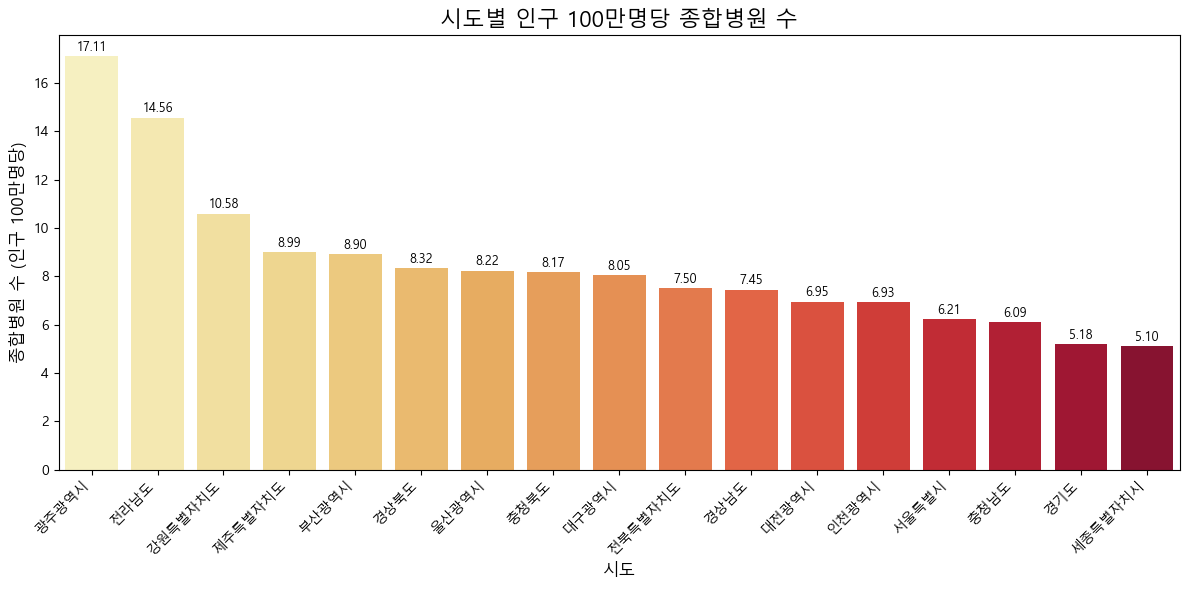

In [38]:
# 인구 100만 명당 종합병원 수 시각화
plot_facility_per_population(
    facility_df=hos_df_f,
    pop_df=pop_by_sido,
    facility_name='종합병원',
    unit=1000000
)

#### 2) 인구 100만명 대비 병원수

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_24568\3573288514.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged, x='Sido', y=col_name, palette=palette)


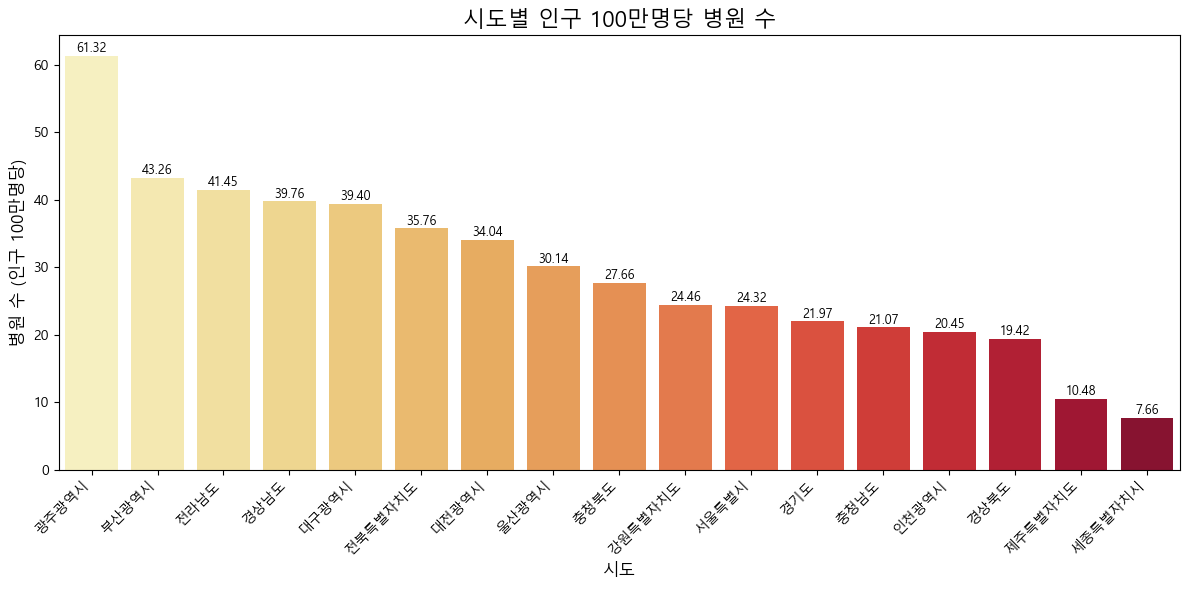

In [39]:
# 인구 100만 명당 병원 수 시각화
plot_facility_per_population(
    facility_df=hos_df_f,
    pop_df=pop_by_sido,
    facility_name='병원',
    unit=1000000
)

#### 3) 인구 1만명 대비 의원수

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_24568\3573288514.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged, x='Sido', y=col_name, palette=palette)


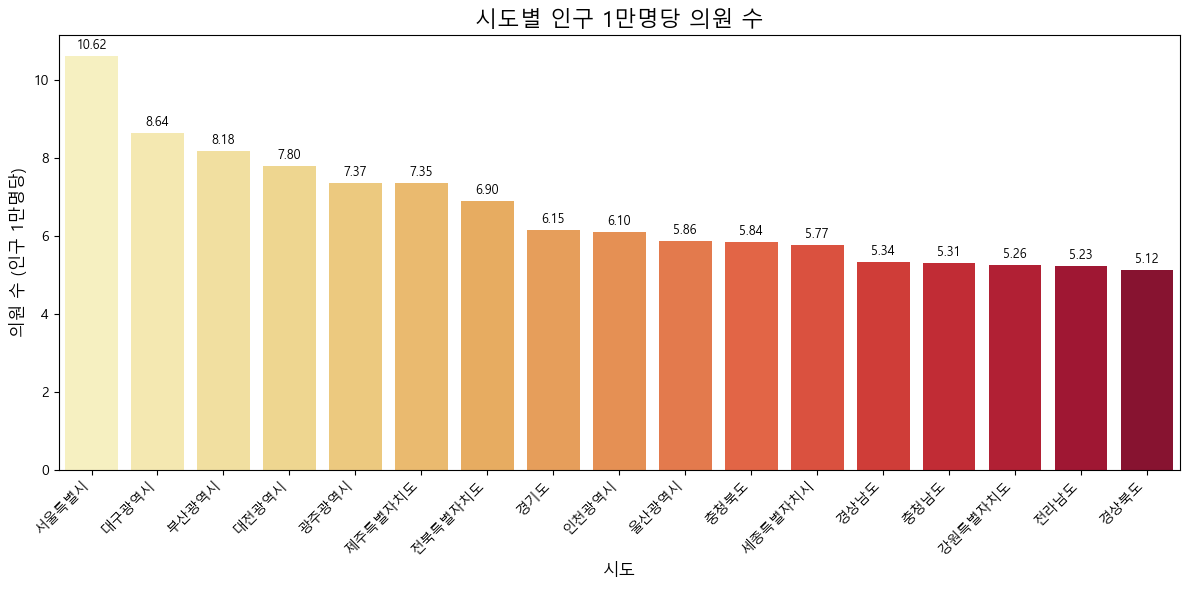

In [40]:
# 인구 1만 명당 의원수 시각화
plot_facility_per_population(
    facility_df=hos_df_f,
    pop_df=pop_by_sido,
    facility_name='의원',
    unit=10000
)

#### 4) 인구 100만명 대비 치과병원수

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_24568\3573288514.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged, x='Sido', y=col_name, palette=palette)


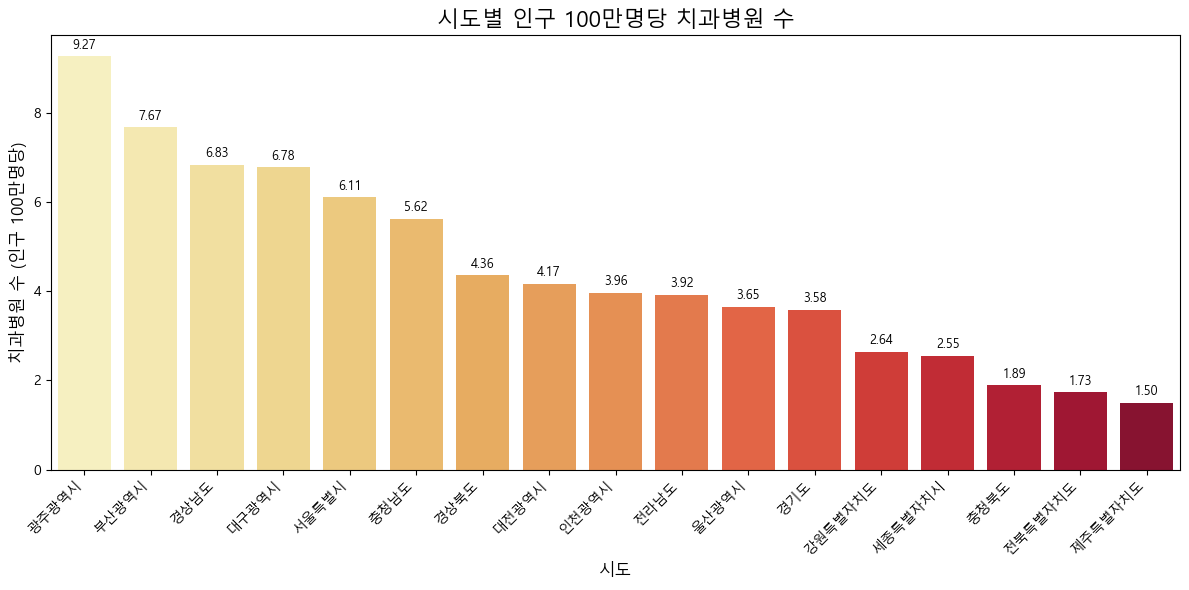

In [41]:
# 인구 100만 명당 치과병원수 시각화
plot_facility_per_population(
    facility_df=hos_df_f,
    pop_df=pop_by_sido,
    facility_name='치과병원',
    unit=1000000
)

#### 5) 인구 10만명 대비 치과의원수

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_24568\3573288514.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged, x='Sido', y=col_name, palette=palette)


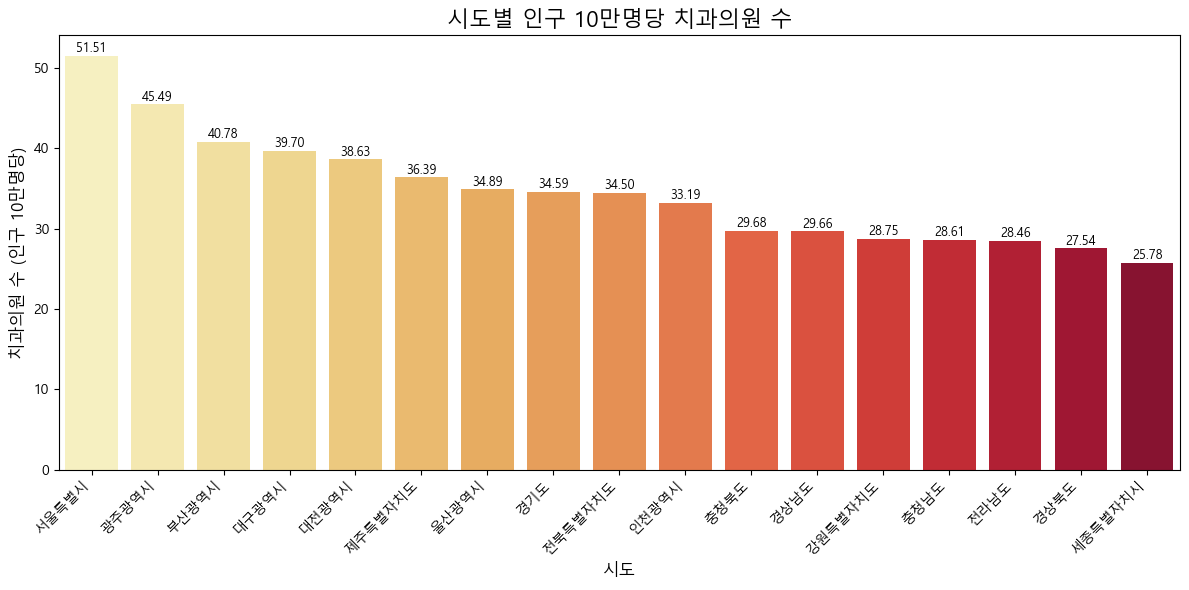

In [42]:
# 인구 10만 명당 치과의원수 시각화
plot_facility_per_population(
    facility_df=hos_df_f,
    pop_df=pop_by_sido,
    facility_name='치과의원',
    unit=100000
)

#### 6) 인구 100만명 대비 요양병원수

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_24568\3573288514.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged, x='Sido', y=col_name, palette=palette)


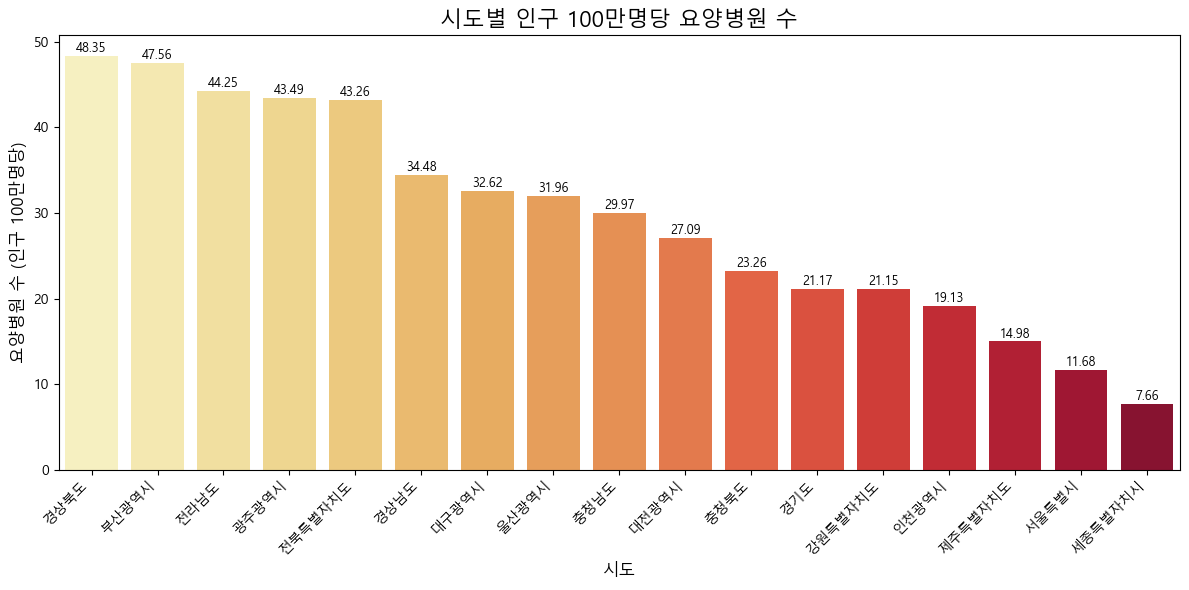

In [43]:
# 인구 100만명당 요양병원수 시각화
plot_facility_per_population(
    facility_df=hos_df_f,
    pop_df=pop_by_sido,
    facility_name='요양병원',
    unit=1000000
)

#### 7) 인구 100만명 대비 한방병원수

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_24568\3573288514.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged, x='Sido', y=col_name, palette=palette)


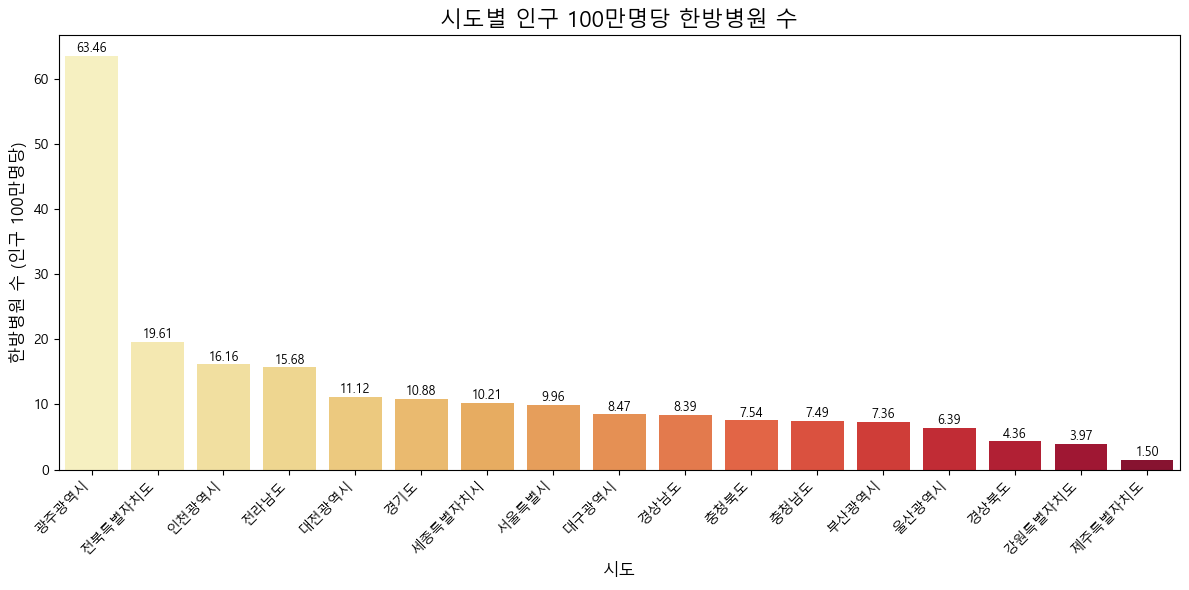

In [44]:
# 인구 100만명당 한방병원수 시각화
plot_facility_per_population(
    facility_df=hos_df_f,
    pop_df=pop_by_sido,
    facility_name='한방병원',
    unit=1000000
)

#### 8) 인구 10만명 대비 한의원 수

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_24568\3573288514.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged, x='Sido', y=col_name, palette=palette)


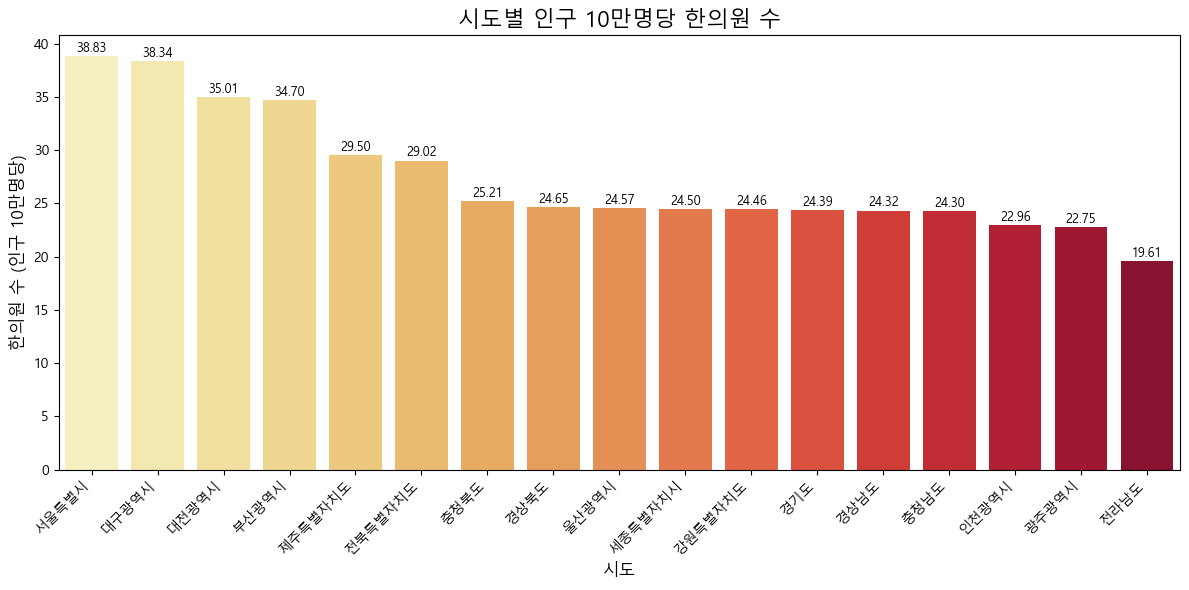

In [45]:
# 인구 10만명당 한의원 수 시각화
plot_facility_per_population(
    facility_df=hos_df_f,
    pop_df=pop_by_sido,
    facility_name='한의원',
    unit=100000
)

#### 9) 인구 10만명 대비 약국수

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_24568\3573288514.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged, x='Sido', y=col_name, palette=palette)


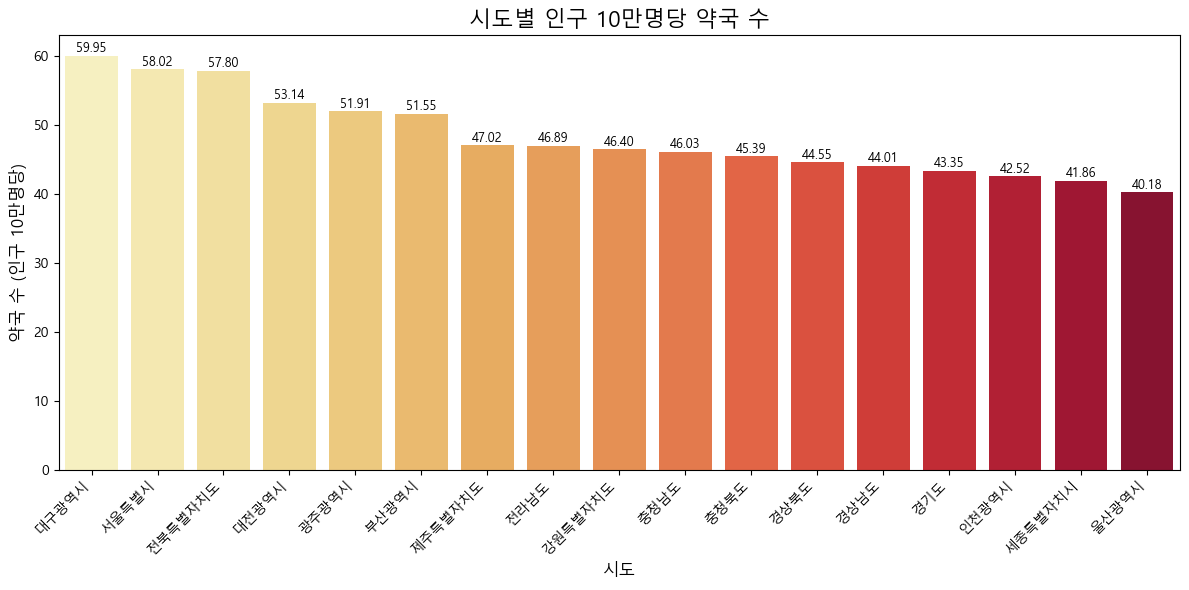

In [46]:
# 인구 10만명당 약국 수 시각화
plot_facility_per_population(
    facility_df=ph_df_f,
    pop_df=pop_by_sido,
    facility_name='약국',
    unit=100000
)

### 5-1-2) 시군구에 대한 의료기관 통계 (상위 15개만 추출)

#### 1) 인구 100만명 대비 종합병원수

In [47]:
# 시군구별 인구 데이터 준비
pop_by_sigungu = pl_df_f.groupby('Sigungu')['pl_count'].sum().reset_index()

# 의료기관 통계 및 시각화를 위한 사용자 정의 함수
def plot_facility_per_population(
    facility_df,               # 병원/약국/시설 데이터프레임
    pop_df,                    # 인구 데이터프레임 (Sido, pl_count 필요)
    facility_name,             # 필터링할 시설 이름 (예: '한의원', '요양병원')
    unit=100000,               # 인구 기준 단위 (예: 100000 → 10만명당)
    palette='YlOrRd'           # 색상 팔레트
):
    # 시설 필터링
    filtered = facility_df[facility_df['dutyDivNam'] == facility_name]

    # 시군구별 시설 수 집계
    count_by_sigungu = filtered.groupby('Sigungu').size().reset_index(name='facility_count')

    # 병합: 시군구별 인구 수와 시설 수
    merged = pd.merge(count_by_sigungu, pop_df, on='Sigungu')

    # 인구 단위당 시설 수 계산
    col_name = f'{facility_name}_per_{unit//10000}만명'
    merged[col_name] = (merged['facility_count'] / merged['pl_count'] * unit).round(2)

    # 정렬
    merged = merged.sort_values(by=col_name, ascending=False)
    
    # 기존 merged 데이터에서 상위 15개만 추출
    merged_top = merged.head(15)
    
    # 시각화
    plt.figure(figsize=(12, 6))
    sns.barplot(data=merged_top, x='Sigungu', y=col_name, palette=palette)

    plt.title(f'시군구별 인구 {unit//10000}만명당 {facility_name} 수', fontsize=16)
    plt.ylabel(f'{facility_name} 수 (인구 {unit//10000}만명당)', fontsize=12)
    plt.xlabel('시군구', fontsize=12)
    plt.xticks(rotation=45, ha='right')

    for i, val in enumerate(merged_top[col_name]):
        plt.text(i, val + 0.1, f"{val:.2f}", ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_24568\1238165079.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_top, x='Sigungu', y=col_name, palette=palette)


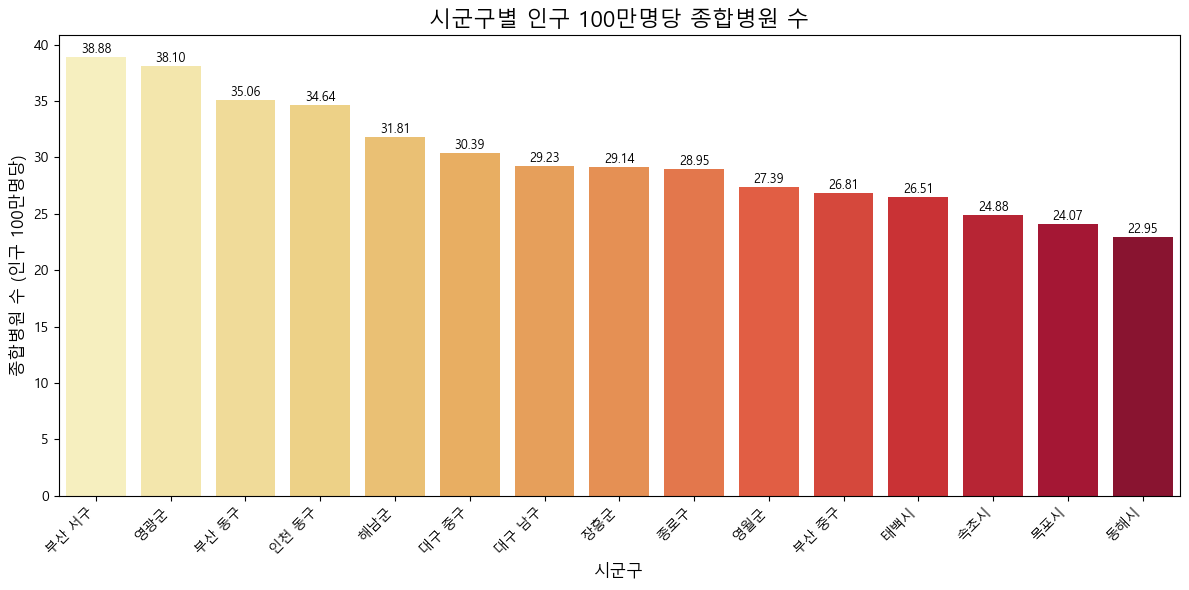

In [48]:
# 인구 100만 명당 종합병원 수 시각화
plot_facility_per_population(
    facility_df=hos_df_f,
    pop_df=pop_by_sigungu,
    facility_name='종합병원',
    unit=1000000
)

#### 2) 인구 100만명 대비 병원수

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_24568\1238165079.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_top, x='Sigungu', y=col_name, palette=palette)


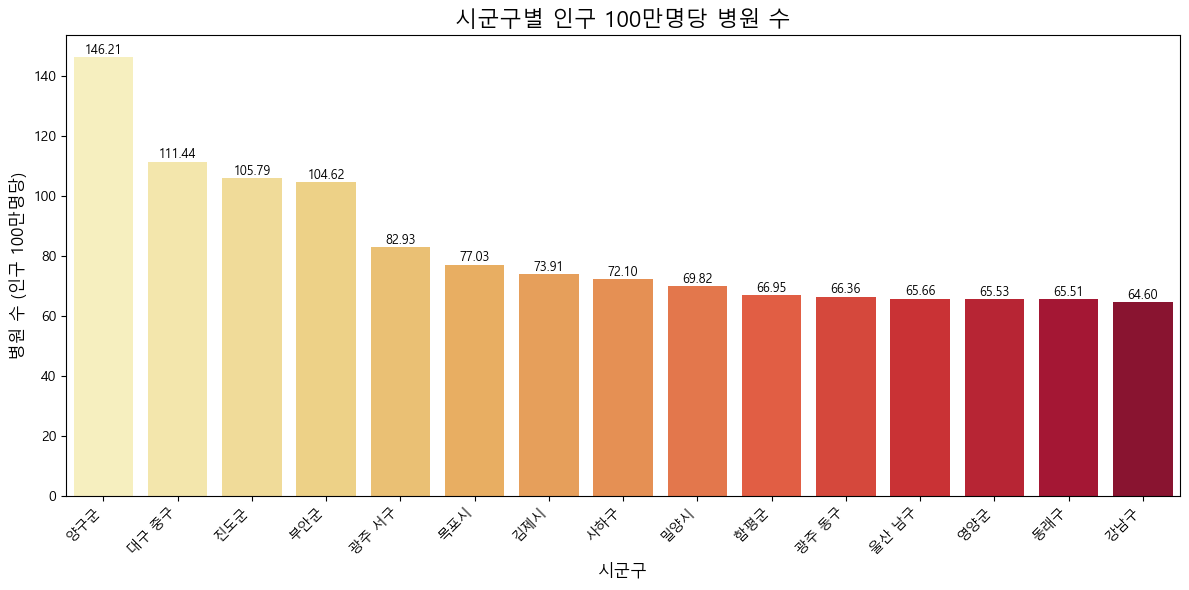

In [49]:
# 인구 100만 명당 병원 수 시각화
plot_facility_per_population(
    facility_df=hos_df_f,
    pop_df=pop_by_sigungu,
    facility_name='병원',
    unit=1000000
)

#### 3) 인구 1만명 대비 의원수

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_24568\1238165079.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_top, x='Sigungu', y=col_name, palette=palette)


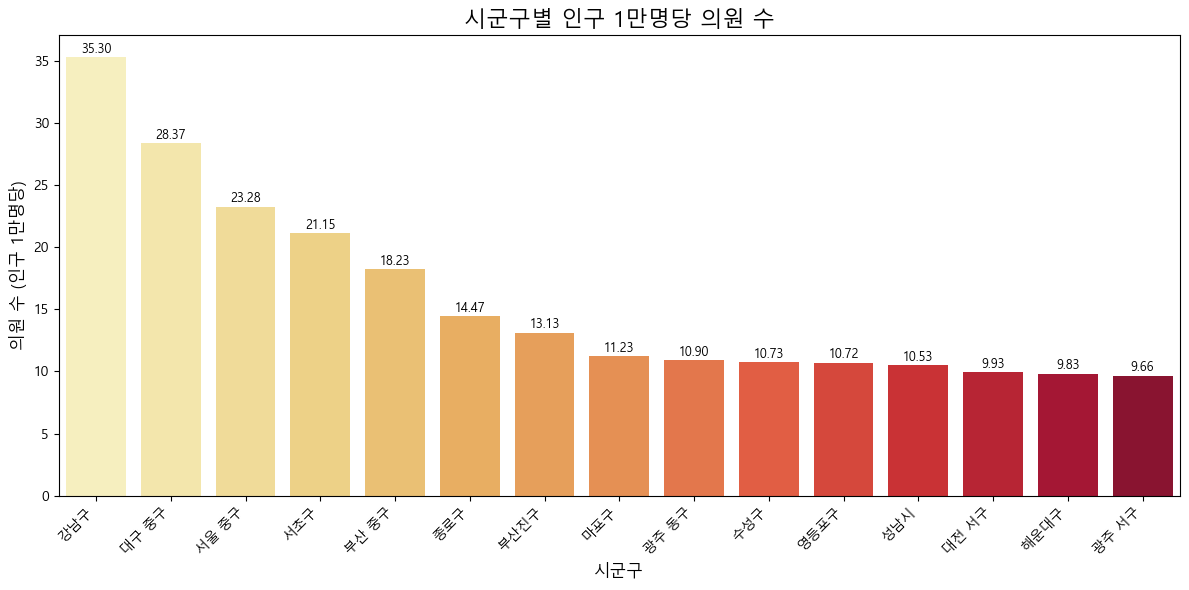

In [50]:
# 인구 1만 명당 의원 수 시각화
plot_facility_per_population(
    facility_df=hos_df_f,
    pop_df=pop_by_sigungu,
    facility_name='의원',
    unit=10000
)

#### 4) 인구 100만명 대비 치과병원수

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_24568\1238165079.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_top, x='Sigungu', y=col_name, palette=palette)


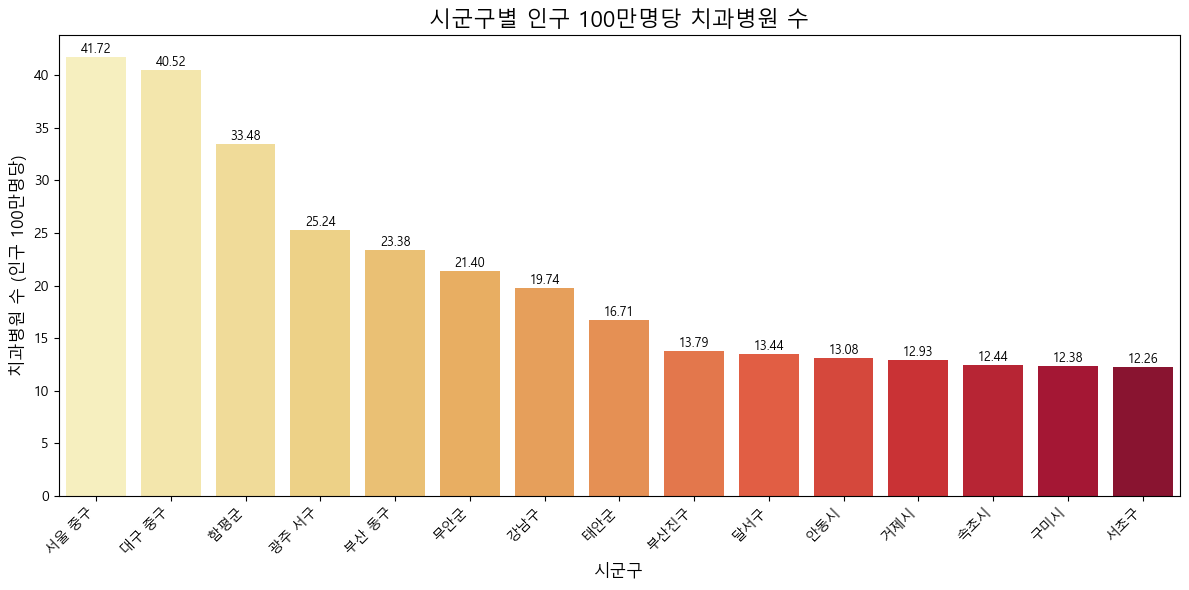

In [51]:
# 인구 100만 명당 치과병원 수 시각화
plot_facility_per_population(
    facility_df=hos_df_f,
    pop_df=pop_by_sigungu,
    facility_name='치과병원',
    unit=1000000
)

#### 5) 인구 10만명 대비 치과의원수

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_24568\1238165079.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_top, x='Sigungu', y=col_name, palette=palette)


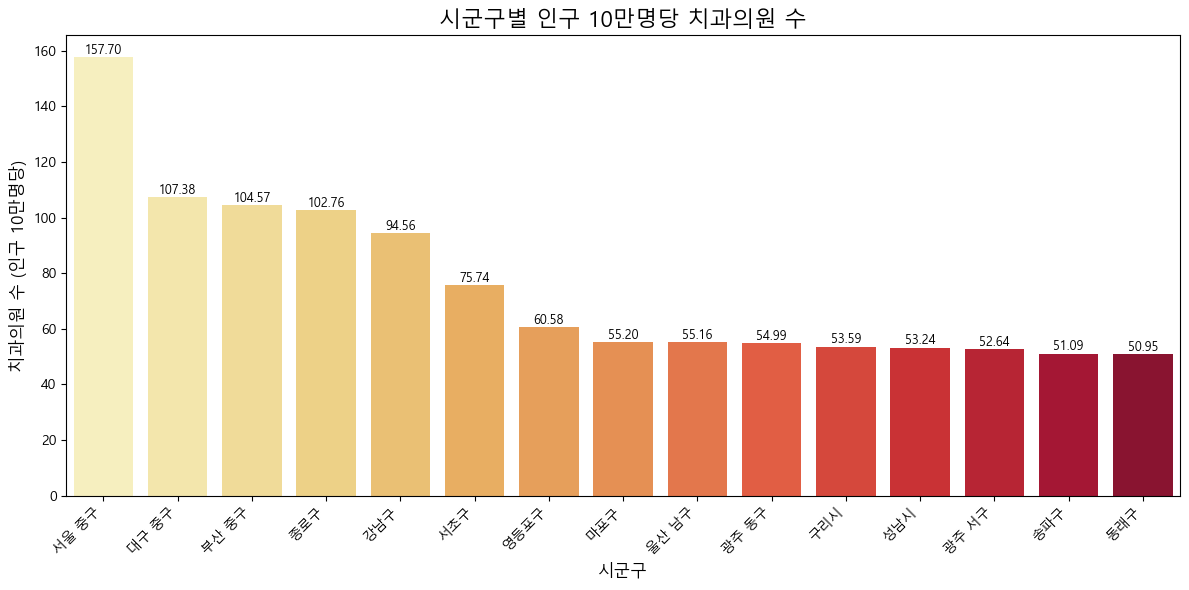

In [52]:
# 인구 10만 명당 치과의원 수 시각화
plot_facility_per_population(
    facility_df=hos_df_f,
    pop_df=pop_by_sigungu,
    facility_name='치과의원',
    unit=100000
)

#### 6) 인구 100만명 대비 치과병원수

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_24568\1238165079.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_top, x='Sigungu', y=col_name, palette=palette)


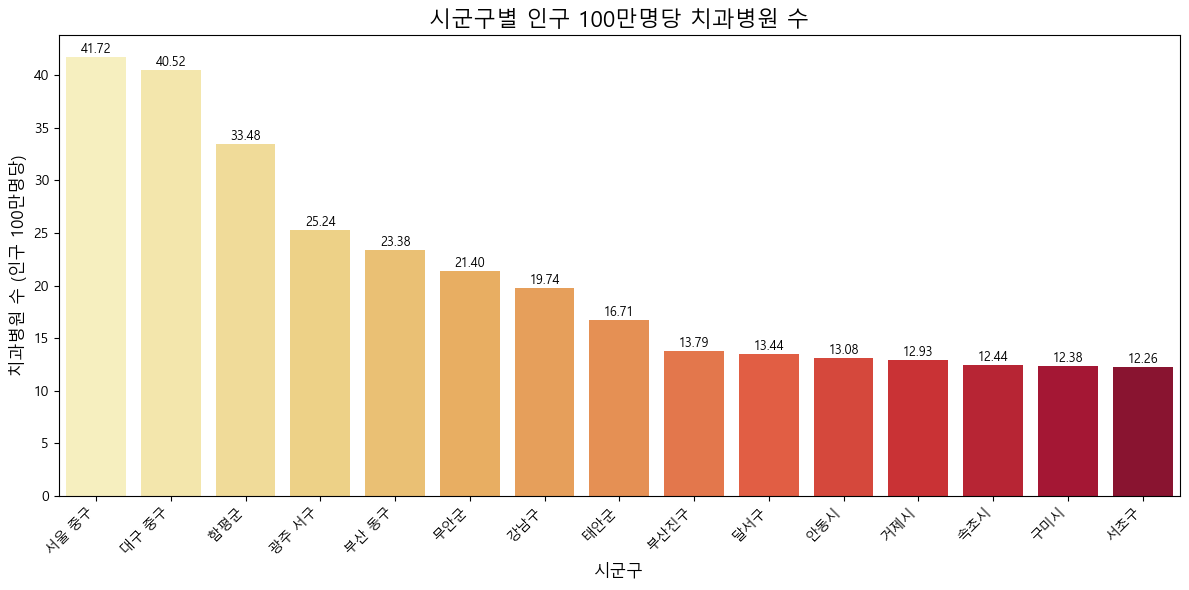

In [53]:
# 인구 100만 명당 치과병원 수 시각화
plot_facility_per_population(
    facility_df=hos_df_f,
    pop_df=pop_by_sigungu,
    facility_name='치과병원',
    unit=1000000
)

#### 7) 인구 100만명 대비 한방병원수

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_24568\1238165079.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_top, x='Sigungu', y=col_name, palette=palette)


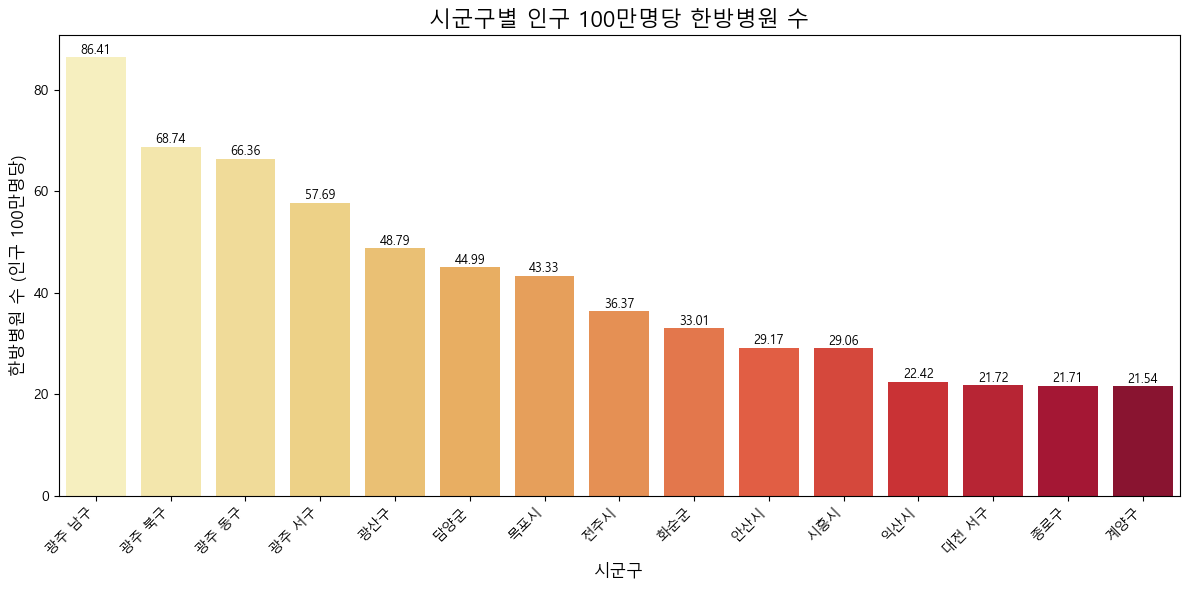

In [54]:
# 인구 100만 명당 한방병원 수 시각화
plot_facility_per_population(
    facility_df=hos_df_f,
    pop_df=pop_by_sigungu,
    facility_name='한방병원',
    unit=1000000
)

#### 8) 인구 10만명 대비 한의원수

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_24568\1238165079.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_top, x='Sigungu', y=col_name, palette=palette)


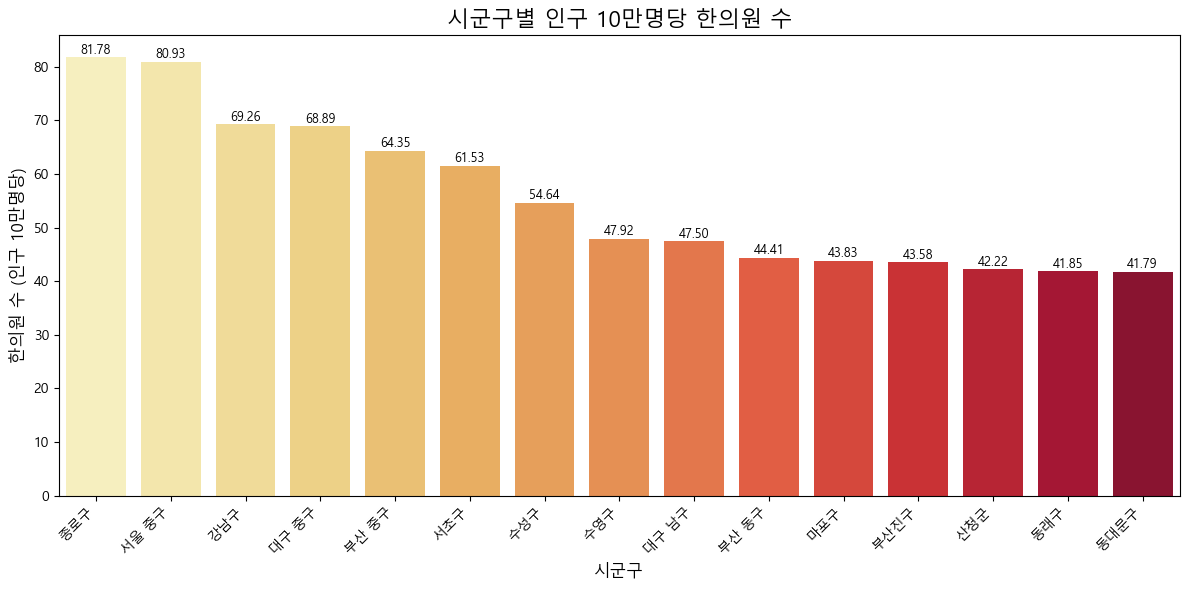

In [55]:
# 인구 10만 명당 한의원 수 시각화
plot_facility_per_population(
    facility_df=hos_df_f,
    pop_df=pop_by_sigungu,
    facility_name='한의원',
    unit=100000
)

#### 9) 인구 10만명 대비 약국수

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_24568\1238165079.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_top, x='Sigungu', y=col_name, palette=palette)


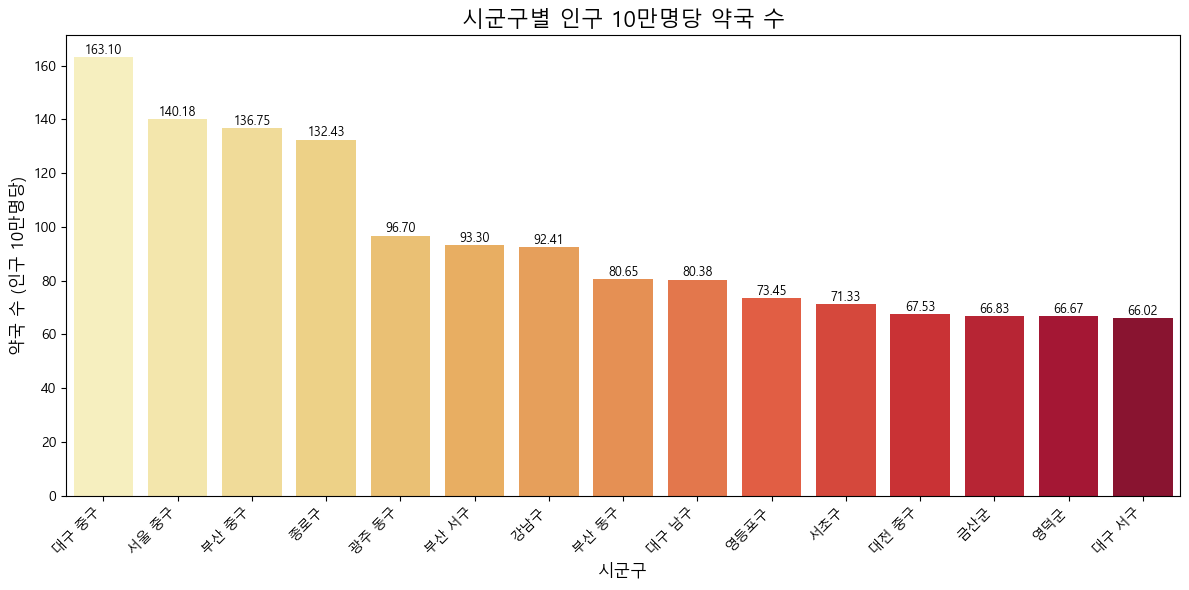

In [56]:
# 인구 10만명당 약국 수 시각화
plot_facility_per_population(
    facility_df=ph_df_f,
    pop_df=pop_by_sigungu,
    facility_name='약국',
    unit=100000
)

## 5-2) 고령 인구 관련 Feature

### 5-2-1) 시도 단위 집계 고령 인구

In [57]:
# total_pop / pl_count	전체 인구
# aged_65_plus	65세 이상 인구 수
# aged_ratio	65세 이상 비율 (aged_65_plus / total_pop × 100)
# super_aged_area	aged_ratio > 20%이면 1, 아니면 0 (초고령 지역 여부 플래그)

# 고령 인구 컬럼 이름 변경
pl_df_f.rename(columns={'고령 인구': 'aged_65_plus'}, inplace=True)

# 고령 인구 비율 계산
pl_df_f['aged_ratio'] = (pl_df_f['aged_65_plus'] / pl_df_f['pl_count'] * 100).round(2)

# 초고령 지역 여부 라벨링 (20% 이상)
pl_df_f['super_aged_area'] = pl_df_f['aged_ratio'].apply(lambda x: 1 if x >= 20 else 0)

# 시도 단위 집계
aged_pop_by_sido = pl_df_f.groupby(['Sido'])[['pl_count', 'aged_65_plus']].sum().reset_index()

# 시도별 aged_ratio 계산
aged_pop_by_sido['aged_ratio'] = (
    aged_pop_by_sido['aged_65_plus'] / aged_pop_by_sido['pl_count'] * 100
).round(2)

# aged_ratio 기준으로 내림차순 정렬 후 상위 5개 확인
aged_pop_by_sido.sort_values(by='aged_ratio', ascending=False).head(5)

,Sido,pl_count,aged_65_plus,aged_ratio
12,전라남도,1785193,491208,27.52
3,경상북도,2523173,667063,26.44
0,강원특별자치도,1512969,390774,25.83
13,전북특별자치도,1733574,444211,25.62
7,부산광역시,3259219,791106,24.27


### 5-2-2) 시군구 단위 집계 고령 인구

In [58]:
# 시도 단위 집계
aged_pop_by_sigungu = pl_df_f.groupby(['Sido', 'Sigungu'])[['pl_count', 'aged_65_plus']].sum().reset_index()

# 시군구별 aged_ratio 계산
aged_pop_by_sigungu['aged_ratio'] = (
    aged_pop_by_sigungu['aged_65_plus'] / aged_pop_by_sigungu['pl_count'] * 100
).round(2)

# aged_ratio 기준으로 내림차순 정렬 후 상위 5개 확인
aged_pop_by_sigungu.sort_values(by='aged_ratio', ascending=False).head(5)

,Sido,Sigungu,pl_count,aged_65_plus,aged_ratio
84,경상북도,의성군,48456,23315,48.12
94,대구광역시,군위군,22444,10729,47.80
166,전라남도,고흥군,60052,27611,45.98
66,경상남도,합천군,39869,18280,45.85
85,경상북도,청도군,40437,18115,44.80


### 5-3) 종합 분석

#### 5-3-1) 시도에 대한 병원수/약국 밀도: 인구 1만명 당 병원, 약국수

In [59]:
# 시도별 병원/약국 수, 인구 수 집계
# 시도별 병원 수 집계
hos_count_by_sido = hos_df_f.groupby('Sido').size().reset_index(name='hos_count')

# 시도별 약국 수 집계
ph_count_by_sido = ph_df_f.groupby('Sido').size().reset_index(name='ph_count')

# pl_df_f의 '계' 열의 이름을 'Count'로 변경
pl_df_f.rename(columns={'계': 'pl_count'}, inplace=True)

# 시도별 인구 수 집계
pop_by_sido = pl_df_f.groupby('Sido')['pl_count'].sum().reset_index()

In [60]:
# 병원/약국/인구 데이터 병합
# 병원 + 약국 병합
facility_by_sido = pd.merge(hos_count_by_sido, ph_count_by_sido, on='Sido', how='outer')

# 인구와 병합
merged_by_sido = pd.merge(facility_by_sido, pop_by_sido, on='Sido', how='left')

병원 밀도 기준으로 오름차순 정렬

In [61]:
# 밀도계산: 인구 100만명당 병원/약국 수 rate: 비율
merged_by_sido['hos_rate'] = (merged_by_sido['hos_count'] / merged_by_sido['pl_count'] * 10000).round(2)
merged_by_sido['ph_rate'] = (merged_by_sido['ph_count'] / merged_by_sido['pl_count'] * 10000).round(2)

# 병원 밀도 기준으로 오름차순 정렬
result_by_sido = merged_by_sido.sort_values(by='hos_rate', ascending=True)

df_result = result_by_sido[['Sido', 'pl_count', 'hos_count', 'hos_rate']].copy()
df_result.head(5)

,Sido,pl_count,hos_count,hos_rate
9,세종특별자치시,391812,454,11.59
11,인천광역시,3031361,3829,12.63
0,강원특별자치도,1512969,1947,12.87
10,울산광역시,1095014,1410,12.88
1,경기도,13699381,17720,12.93


약국 비율 기준으로 오름차순 정렬

In [62]:
# 약국 비율 기준으로 오름차순 정렬
result_by_sido = merged_by_sido.sort_values(by='ph_rate', ascending=True)

df_result = result_by_sido[['Sido', 'pl_count', 'ph_count', 'ph_rate']].copy()
df_result.head(5)

,Sido,pl_count,ph_count,ph_rate
10,울산광역시,1095014,440,4.02
9,세종특별자치시,391812,164,4.19
11,인천광역시,3031361,1289,4.25
1,경기도,13699381,5939,4.34
2,경상남도,3219574,1417,4.40


#### 5-3-1) 시군구에 대한 병원 슈/약국 밀도: 인구 1만명당 병원, 약국수

In [63]:
# 시도 + 시군구 단위 병원 수 집계
hos_count_by_sigungu = hos_df_f.groupby(['Sido', 'Sigungu']).size().reset_index(name='hos_count')

# 시도 + 시군구 단위 약국 수 집계
ph_count_by_sigungu = ph_df_f.groupby(['Sido', 'Sigungu']).size().reset_index(name='ph_count')
 
# 시도 + 시군구 단위 인구 수 집계
pop_by_sigungu = pl_df_f.groupby(['Sido', 'Sigungu'])['pl_count'].sum().reset_index()

In [64]:
# 병원/약국/인구 데이터 병합
# 병원 + 약국 병합
facility_by_sigungu = pd.merge(hos_count_by_sigungu, ph_count_by_sigungu, on='Sigungu', how='outer')

# 인구와 병합
merged_by_sigungu = pd.merge(facility_by_sigungu, pop_by_sigungu, on='Sigungu', how='left')

병원 비율 기준으로 오름차순 정렬

In [65]:
# 비율계산: 인구 1만명당 병원/약국 수
merged_by_sigungu['hos_rate'] = (merged_by_sigungu['hos_count'] / merged_by_sigungu['pl_count'] * 10000).round(2)
merged_by_sigungu['ph_rate'] = (merged_by_sigungu['ph_count'] / merged_by_sigungu['pl_count'] * 10000).round(2)

# 병원 비율 기준으로 오름차순 정렬
result_by_sigungu = merged_by_sigungu.sort_values(by='hos_rate', ascending=True)

df_result = result_by_sigungu[['Sido', 'Sigungu', 'pl_count', 'hos_count', 'hos_rate']].copy()
df_result.head(10)

,Sido,Sigungu,pl_count,hos_count,hos_rate
82,경상북도,울릉군,9040,6,6.64
35,경기도,양주시,290250,236,8.13
164,인천광역시,인천 중구,171635,145,8.45
152,울산광역시,울산 북구,215755,187,8.67
111,부산광역시,부산 강서구,142703,127,8.90
22,경기도,광주시,396930,355,8.94
9,강원특별자치도,인제군,31146,28,8.99
154,울산광역시,울주군,218402,202,9.25
6,강원특별자치도,양양군,27452,26,9.47
44,경기도,파주시,515493,504,9.78


약국 비율 기준으로 오름차순 정렬

In [66]:
# 약국 비율 기준으로 오름차순 정렬
result_by_sigungu = merged_by_sigungu.sort_values(by='ph_rate', ascending=True)

df_result = result_by_sigungu[['Sido', 'Sigungu', 'pl_count', 'ph_count', 'ph_rate']].copy()
df_result.head(10)

,Sido,Sigungu,pl_count,ph_count,ph_rate
176,전라남도,신안군,38694,7,1.81
161,인천광역시,옹진군,19796,4,2.02
82,경상북도,울릉군,9040,2,2.21
78,경상북도,영양군,15261,4,2.62
152,울산광역시,울산 북구,215755,58,2.69
41,경기도,의왕시,153951,47,3.05
111,부산광역시,부산 강서구,142703,44,3.08
154,울산광역시,울주군,218402,68,3.11
94,대구광역시,군위군,22444,7,3.12
81,경상북도,예천군,54301,17,3.13


## 6. 모델링_진행해야 함

In [67]:
# 1. 의료취약지 예측 모델링 (분류 문제)
# ulnerable_label:
# 1 = 인구는 많은데 의료시설 부족 (hos_rate or facility_rate 기준 미달)
# 0 = 양호한 지역
#추천 모델:
# Decision Tree, Random Forest, XGBoost, Logistic Regression

# 2. 클러스터링을 통한 취약지 유형 분류 (비지도 학습)
# 유사한 특성을 지닌 읍면동끼리 묶어, 의료 인프라 상황이 비슷한 클러스터로 구분
# hos_rate, ph_rate, aged_ratio, population_density, 시설 밀도 등
# 추천 기법:
# KMeans, DBSCAN, Hierarchical Clustering
#PCA 또는 t-SNE로 차원 축소 후 시각화
# 결과 해석 예시:
# Cluster 0: 고령인구 많고 병원 적은 지역 → 방문진료 필요
# Cluster 1: 고령인구 적고 시설 밀도 높음 → 양호

# 3. 회귀분석을 통한 의료시설 수 결정 요인 분석 (얘는 사용불가)
# 어떤 요인이 병원/약국 수에 영향을 미치는가?**를 설명하는 모델
# 타겟:
# hos_count 또는 facility_rate (연속형 변수)
#📊 독립변수 예시:
# pl_count, aged_ratio, 지역별 소득, 도로 접근성, 행정 중심지 여부
# 🛠 추천 모델:
#Linear Regression, Poisson Regression (count data), Ridge/Lasso
#✅ 인사이트 예시:
#고령인구 비율이 높고 인구밀도가 낮은 지역일수록 병원 수가 적은 경향이 있음

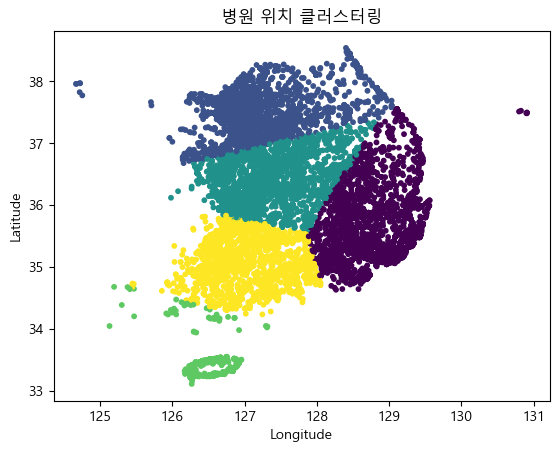

In [69]:
# 지도 기반 군집화(Clustering)
# 위도 경도 기반 클러스터링
geo_df = hos_df[['wgs84Lat', 'wgs84Lon']].dropna()

# KMeans 군집화
kmeans = KMeans(n_clusters=5, random_state=42)
geo_df['cluster'] = kmeans.fit_predict(geo_df[['wgs84Lat', 'wgs84Lon']])

# 시각화
plt.scatter(geo_df['wgs84Lon'], geo_df['wgs84Lat'], c=geo_df['cluster'], s=10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('병원 위치 클러스터링')
plt.show()

### 6-1) 회귀분석을 통한 의료시설 수 결정 요인 분석

In [ ]:
# 시도와 시군구로 나누면서 계속 진행해 왔으니 회귀분석을 한다고 했으면 시도, 시군구에 대한 모델링을 2개 진행해야하는건가...?

## 7. 이미지 시각화_권혁규 코드

### 1) 지도 생성

In [94]:
# 각 데이터 복사
hos_df = hos_df_hang.copy() # 병원 데이터
ph_df = ph_df_hang.copy() # 약국 데이터
pl_df = pl_df_hang.copy() # 인구 데이터

# 병원/약국/보건소에 'type' 열 추가
hos_df['type'] = '병원'
ph_df['type'] = '약국'

# 세로 결합을 위해 필요한 열만 선택
common_cols = ['Jibun', 'Hang', 'Sido', 'Sigungu', 'Eupmywondong', 'wgs84Lat', 'wgs84Lon', 'type']

hos_sel = hos_df[common_cols]
ph_sel = ph_df[common_cols]

# 세로 방향으로 결합
full_df = pd.concat([hos_sel, ph_sel], ignore_index=True)

In [95]:
# 아이콘 설정 함수
def get_icon(category):

    # 병원과 약국에 따라 아이콘 색상과 모양이 다르게 설정
    color = "red" if category == "병원" else "green"
    icon = "medkit" if category == "병원" else "pills"
    return folium.Icon(color=color, icon=icon, prefix='fa')

# 지도 생성 함수
def create_maps_by_region(df, grouped, output_dir='캡스톤 법정동 지도'):
    os.makedirs(output_dir, exist_ok=True)

    # 각 지역 단위로 그룹화된 데이터를 순회
    for region, group in grouped:

        # 위도나 경도가 없는 행 제거
        valid_group = group.dropna(subset=["wgs84Lat", "wgs84Lon"])
        if valid_group.empty:
            continue

        # 지도 초기화: 해당 지역의 중심 좌표로 생성
        m = folium.Map(
            location=[valid_group["wgs84Lat"].mean(), valid_group["wgs84Lon"].mean()],
            zoom_start=13
        )

        # 병원과 약국 각각에 대한 처리
        for category in ['병원', '약국']:
            sub = valid_group[valid_group["type"] == category]
            if sub.empty:
                continue

            # 병원 또는 약국의 위도/경도 배열 추출
            coords = sub[["wgs84Lat", "wgs84Lon"]].to_numpy()

            # DBSCAN 파라미터: 1km 이내의 클러스터 찾기
            epsilon = 1.0 / 6371.0088  # 지구 반지름을 이용한 라디안 거리

            # DBSCAN 클러스터링 (하버사인 거리 기준)
            db = DBSCAN(eps=epsilon, min_samples=2, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
            
            sub = sub.copy()
            sub["cluster"] = db.labels_

            # 각 클러스터에 대해 처리
            for cluster_id in sub["cluster"].unique():
                cluster_points = sub[sub["cluster"] == cluster_id]
                cluster_coords = cluster_points[["wgs84Lat", "wgs84Lon"]].to_numpy()

                # 클러스터 중심 계산
                center_lat = cluster_coords[:, 0].mean()
                center_lon = cluster_coords[:, 1].mean()
                max_dist = max(great_circle((center_lat, center_lon), (lat, lon)).meters for lat, lon in cluster_coords)
                radius = max_dist + 10000

                # 클러스터 중심으로 원 그리기
                folium.Circle(
                    location=(center_lat, center_lon),
                    radius=radius,
                    color='red' if category == '병원' else 'green',
                    weight=2,
                    fill=True,
                    fill_color='red' if category == '병원' else 'green',
                    fill_opacity=0.1
                ).add_to(m)

                # 각 기관 위치에 마커 추가
                for _, row in cluster_points.iterrows():
                    popup_text = f"주소: {row.get('Jibun', 'N/A')}"
                    folium.Marker(
                        location=(row["wgs84Lat"], row["wgs84Lon"]),
                        popup=folium.Popup(popup_text, max_width=300),
                        icon=get_icon(category)
                    ).add_to(m)

        # HTML 파일로 지도 저장
        m.save(os.path.join(output_dir, f"{region}.html"))

    # 전체 지도 HTML 파일들을 ZIP으로 압축
    zip_path = output_dir + ".zip"
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for file in os.listdir(output_dir):
            zipf.write(os.path.join(output_dir, file), arcname=file)

In [ ]:
# Sido를 기준으로 지도 생성
create_maps_by_region(full_df, full_df.groupby('Sido'))

### 2) 인구수 시각화

In [54]:
# 법정동 지도 폴더 경로
root_folder = r"C:/Users/Admin/OneDrive/캡스톤 코드/캡스톤 법정동 지도"

# 저장할 폴더 만들기
os.makedirs('C:/Users/Admin/OneDrive/캡스톤/시도별 지도', exist_ok=True)

# 시도별 폴더 목록 가져오기
sido_folders = [f.path for f in os.scandir(root_folder) if f.is_dir()]

In [55]:
# 인구수 시각화를 위한 색상 지정
colormap_list = [
    cm.linear.Blues_09,   # 파랑 계열
    cm.linear.Greens_09,  # 초록 계열
    cm.linear.Purples_09, # 보라 계열
    cm.linear.Reds_09,    # 빨강 계열
    cm.linear.Oranges_09  # 주황 계열
]

# 지도 생성 함수
def create_map(geo_df, output_path):
    
    # 지도 초기화 - 전체 중심 좌표로 지도 생성
    center = geo_df.geometry.centroid.unary_union.centroid
    m = folium.Map(location=[center.y, center.x], zoom_start=7)

    # 시군구별로 반복하여 GeoJson 층 생성
    for sigungu in geo_df['Sigungu'].unique():
        
        # 해당 시군구만 필터링
        subset = geo_df[geo_df['Sigungu'] == sigungu]

        # 인구수가 0인 격자(읍면동)는 제외
        subset = subset[subset['계'] > 0]
        if subset.empty:
            continue  # 해당 시군구에 인구가 없으면 건너뜀

        # 랜덤 색상 맵 선택 후, 해당 시군구의 인구 min/max에 맞춰 색상 스케일 조정
        cmap = random.choice(colormap_list).scale(
            subset['계'].min(), subset['계'].max()
        )

        # 각 읍면동의 인구수에 따라 색상을 지정하는 스타일 함수 정의
        def style_fn(feat, cmap=cmap):
            val = feat['properties']['계']
            return {
                'fillColor': cmap(val),       # 인구수에 따른 색상
                'color': 'black',             # 외곽선 색 (시군구 경계선)
                'weight': 1,                  # 외곽선 두께
                'fillOpacity': 0.7            # 채우기 투명도
            }

        # folium GeoJson 객체로 시각화, 툴팁 및 팝업 포함
        folium.GeoJson(
            subset.to_json(),                # GeoDataFrame을 GeoJSON 형식으로 변환
            style_function=style_fn,        # 스타일 지정
            tooltip=GeoJsonTooltip(         # 마우스 오버 시 툴팁 표시
                fields=['EMD_NM','계','Sigungu'],
                aliases=['Eupmywondong','count','Sigungu'],
                localize=True, sticky=True, labels=True, toLocaleString=True
            ),
            popup=GeoJsonPopup(             # 클릭 시 팝업 표시
                fields=['EMD_NM','계','시군구명'],
                aliases=['Eupmywondong','count','Sigungu'],
                localize=True, labels=True, toLocaleString=True
            )
        ).add_to(m)
    
    # 지도 저장
    m.save(output_path)

In [56]:
# 시도별 지도 생성 및 저장
merged_list = []  # 시도별 병합 데이터를 저장할 리스트

# 시도별 폴더 반복
for sido_folder in sido_folders:
    folder_name = os.path.basename(sido_folder)        # 폴더명 추출 (예: 'LSMD_ADM_SECT_UMD_강원')
    folder_short = folder_name[-2:]                    # 폴더명 끝 2글자 (예: '강원')
    sido_name = sido_mapping.get(folder_short)         # 시도명 매핑 (예: '강원특별자치도' → '강원도')

    # 해당 폴더 내의 shp 파일 찾기
    shp_files = glob.glob(os.path.join(sido_folder, '*.shp'))
    shp_file = shp_files[0]                            # 첫 번째 shp 파일 사용
    geo_df = gpd.read_file(shp_file, encoding='euc-kr')  # 공간 정보 불러오기

    # 인구 데이터에서 해당 시도만 필터링
    pl_sido_df = pl_df[pl_df['Sido'] == sido_name].copy()

    # 읍면동 코드 추출 (법정동코드 앞 8자리)
    pl_sido_df['읍면동코드'] = pl_sido_df['법정동코드'].astype(str).str[:8]

    # 시군구, 읍면동코드 기준으로 인구수 합산
    pl_grouped = pl_sido_df.groupby(['시군구명', '읍면동코드'])['계'].sum().reset_index()

    # 시도명 컬럼 추가
    pl_grouped['시도명'] = sido_name

    # 공간정보(geo_df)와 인구 데이터(pl_grouped) 병합
    merged = geo_df.merge(pl_grouped, left_on='EMD_CD', right_on='읍면동코드')

    # 좌표계를 EPSG:4326 (WGS 84)로 변환 (지도 시각화용)
    merged = merged.to_crs(epsg=4326)

    # 병합된 결과를 리스트에 저장
    merged_list.append(merged)

    # 해당 시도의 인구 지도를 저장
    create_map(merged, f'C:/Users/Admin/OneDrive/캡스톤/시도별 지도/{sido_name}_인구_지도.html')